# An examination of the relative price in the Koopman model

In this project we want to examine the relative price set in the Koopman model. We want to see how the price depends on the parameters of the model. In doing so we take two approaches: First, we derive an analytical solution and plot the results in an interattive figure, second, we try to solve the by solving the model numerically. Specifically we use a bisection method. The baseline model assumes that the consumer has a Cobb-Douglas utility function. We extend the model by assuming a CES-utility function.

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [5]:
import numpy as np
from scipy import optimize
import sympy as sm
import ipywidgets as widgets # Interactive plots
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import analytical_solution as ana
import numerical_solution as num
import CES_function as ces

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Model description of baseline model

**Time:** One period.

**Demographics:** Initially one consumer and one firm. The firm is owned by the consumer and therefore the income also depends on the profit. We do not assume initial goods endowments. 

**Household:** For our baseline model we assume that the consumer has Cobb-Douglas preferences, where the two goods are the product (c) and leisure (l)
$$
\begin{aligned}
& \max \ u =c^{\alpha}*l^{1-\alpha}, 0<\alpha<1\\
 & \text{s.t.}\\
 & I=\Pi + w*L=p*c +w*l \\

\end{aligned}
$$

${\alpha}$ is the relative preference towards consumption, p is the price of the good, w is the wage, L is the initial labor endowment, l is leisure and $\Pi$ is the profit. We have assumed monotonicity. Further, we have the firm problem: 
$$
\begin{aligned}
&\Pi =p*y-w*h

\end{aligned}
$$

The production function will be defined as follow, where the interpretation of A can be TFP, and ${\beta}$ determines the returns to scale: 

$$
\begin{aligned}
&y =A*h^{\beta}, \beta <1 \\
&\max \ \Pi =p*A*h^{\beta}-w*h

\end{aligned}
$$

We assume the initial labor endowment is 24 hours, i.e. a day. We can therefore define the following relationsship in equilibrium: 
$$
\begin{aligned}
&L=24=l+h

\end{aligned}
$$




**Equilibrium:** The procedure is defined where the labor market (l+h=24) and good market (y=c) clear. Further, the firm has maximized its profit and the consumer has maximized its utility. 



## 2. Analytical solution

The baseline model can be solved analytically. The starting point is to derive the firm's demand for labor. This is done by taking the FOC of the profit function w.r.t. working hours. This leads to the following result:  

$$
\begin{aligned}
& h^*=(\frac{\beta*p*A}{w})^{\frac{1}{1-\beta}}
\end{aligned}
$$

And from this the solutions for the firm's output and profit follow easily: 

$$
\begin{aligned}
& y^*=A*(\frac{\beta*p*A}{w})^{\frac{\beta}{1-\beta}}\\
& \Pi^*=p*A*(\frac{\beta*p*A}{w})^{\frac{\beta}{1-\beta}}-w(\frac{\beta*p*A}{w})^{\frac{1}{1-\beta}}
\end{aligned}
$$

Now, we will solve for the consumer's problem. It should be noted that the working hours and profit is exogenous for the consumer as the firm has already decided this based on the prices. As we have assumed a Cobb-Douglas function, we can use the standard solution shown below: 

$$
\begin{aligned}
& c^*=\alpha*\frac {I}{p}\\
& l^*=(1-\alpha)*\frac{I}{w}
\end{aligned}
$$

Where the income is: 

$$
\begin{aligned}
& I= \Pi+L = p*A*(\frac{\beta*p*A}{w})^{\frac{\beta}{1-\beta}}-w(\frac{\beta*p*A}{w})^{\frac{1}{1-\beta}} + L
\end{aligned}
$$



Now we want to find the prices in equilibrium, that is, where the goods market and the labor market clears. We set the wage as numeraire, i.e. w=1, and then find the relative price p. We can then solve for the labor market: 

$$
\begin{aligned}
& l^*=L-h^*\\
& \leftrightarrow (1-\alpha)*(p*A*(\beta*p*A)^{\frac{\beta}{1-\beta}}-(\beta*p*A)^{\frac{1}{1-\beta}}+L)=L-(\beta*p*A)^{\frac{1}{1-\beta}}
\end{aligned}
$$

Solving this for p gives: 

$$
\begin{aligned}
& p^*=\frac {L^{1-\beta}}{A}*\frac {1}{(\beta^\frac {\beta}{1-\beta}*(1-\alpha)+\alpha*\beta^\frac {1}{1-\beta})^{1-\beta}}
\end{aligned}
$$

We see that higher productivity (A) decreases the price, which makes intuively sense as this will increase the supply. Further, higher demand ($\alpha$) will increase the price, which again makes intuitively sense. With this price we have the general solution, which can be plotted below. 

Note, given Walras' law, we know that this relative price also solves the goods market.

Now we have the general solution. This can be illustrated by using specific values for the parameters in the model. In the figure below we plot alpha on the x-axis and price on the y-axis, and then we add sliders for the values of $\beta$ and A.

In [17]:
#Interactive figure with beta and A as sliders
widgets.interact(ana.interactive_figure,
    beta=widgets.FloatSlider(description=r"beta", min=0., max=0.99, step=0.10, value=0.5), 
    A=widgets.FloatSlider(description=r"A", min=1, max=10, step=1, value=5),
);

interactive(children=(FloatSlider(value=0.5, description='beta', max=0.99), FloatSlider(value=5.0, description…

What we see from the graph directly follows from the points made above. Further, we see a decreasing relationship with $\beta$, when adjusting the slider for this parameter. This relationship also makes sense given that $\beta$ determines how much returns to scale are decreasing: A higher value of $\beta$ means higher returns to scale and from this follows a higher supply.

## Numerical solution

In this section we solve the model numerically using the bisection method. We use the bisection method, because we know that when the goods market clears, then excess supply should be equal 0. We can use this to find the price that equilibriates supply and demand of the good: If excess supply is positive, then we know that the price is too high, and oppositely if excess supply is negative, then we know that the price is too low. 

**Problem:** Given a list of positive numbers, return the relative price that solves the goods market (and the labor market given Walras' Law).

**Inputs:** A range of possible solutions, and values of alpha, beta, A and L respectively.

**Outputs:** Relative price $p$.

**Algorithm:** `numerical_solution()`

1. For a given $p$, $\beta$, and $\alpha$ determine excess supply on the goods market and excess demand on the labor market following utility and profit maximization.
2. Set tolerance level $\epsilon$, maximum number of iterations, and lower and upper bounds for possible solutions: $p_{lower}$ and $p_{upper}$.
*  Note, the relative price cannot be negative.
3. Compute the excess supply for both the upper and lower bound: $ES(p_{lower})$ and $ES(p_{upper})$
4. Compute midpoint: $p_{mid}=\frac{p_{lower}+p_{upper}}{2}$
5. Compute excess supply for the midpoint: $ES(p_{mid})$
6. Update the interval:
  * If $ES(p_{lower})*ES(p_{mid})<0$ then update so $p_{upper}=p_{mid}$
  * If $ES(p_{mid})*ES(p_{upper})<0$ then update so $p_{lower}=p_{mid}$
7. Repeat step 3-6 until $ES(p_{mid})<\epsilon$

To again examine how the market clearing relative price changes for values of $\alpha$ and $\beta$ we now loop over ranges of values for these two parameters.

In [7]:
#call class
sol=num.numerical_solution()

In [8]:
#Alpha

# a. determine size of vectors
N=10

# b. create empty vectors
alpha_vec_num=np.empty(N)
p_vec_num_alpha=np.empty(N)
c_clearing_alpha=np.empty(N)
l_clearing_alpha=np.empty(N)

# c. loop over the specified amount of alpha values and solve the model numerically each tim
for i, alpha in enumerate(np.linspace(start=0.01, stop = 0.99, num=N)):
    # Call find_relative_price with current alpha value
    alpha_baseline=sol.par.alpha
    sol.par.alpha=alpha
    alpha_vec_num[i]=alpha
    p_vec_num_alpha[i],c_clearing_alpha[i], l_clearing_alpha[i] = sol.find_relative_price(tol=1e-4, p_lower=0, p_upper=1000)
    sol.par.alpha=alpha_baseline

c:\Users\Bruger\IntroProg\projects-2023-andershuus_christianfogel\modelproject\numerical_solution.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  sol.c_star = par.alpha*utility_inc/p


 Step 28.00: p = 0.06 ->  -0.00008752. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 29.00: p = 0.22 ->   0.00006559. Good clearing = 0.00. Labor clearing = 0.00. 
 Step 30.00: p = 0.31 ->   0.00001313. Good clearing = 0.00. Labor clearing = 0.00. 
 Step 30.00: p = 0.39 ->   0.00000732. Good clearing = 0.00. Labor clearing = 0.00. 
 Step 27.00: p = 0.46 ->  -0.00008705. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 28.00: p = 0.54 ->  -0.00007133. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 29.00: p = 0.61 ->  -0.00005713. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 28.00: p = 0.69 ->   0.00003176. Good clearing = 0.00. Labor clearing = 0.00. 
 Step 29.00: p = 0.77 ->   0.00003057. Good clearing = 0.00. Labor clearing = 0.00. 
 Step 34.00: p = 0.86 ->   0.00006475. Good clearing = 0.00. Labor clearing = 0.00. 


In [10]:
#Beta

beta_vec_num=np.empty(N)
p_vec_num_beta=np.empty(N)
c_clearing_beta=np.empty(N)
l_clearing_beta=np.empty(N)

for i, beta in enumerate(np.linspace(start=0.01, stop = 0.8, num=N)):
    # Call find_relative_price with current beta value
    beta_baseline=sol.par.beta
    sol.par.beta=beta
    beta_vec_num[i]=beta
    p_vec_num_beta[i],c_clearing_beta[i], l_clearing_beta[i] = sol.find_relative_price(tol=1e-4, p_lower=0, p_upper=1000, iterations=500)
    sol.par.beta=beta_baseline

c:\Users\Bruger\IntroProg\projects-2023-andershuus_christianfogel\modelproject\numerical_solution.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  sol.c_star = par.alpha*utility_inc/p


 Step 23.00: p = 3.72 ->  -0.00005188. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 22.00: p = 2.84 ->  -0.00007574. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 24.00: p = 2.00 ->   0.00004970. Good clearing = 0.00. Labor clearing = 0.00. 
 Step 26.00: p = 1.38 ->  -0.00005661. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 27.00: p = 0.94 ->  -0.00009904. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 26.00: p = 0.63 ->  -0.00001485. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 27.00: p = 0.42 ->  -0.00006197. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 32.00: p = 0.28 ->  -0.00005416. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 31.00: p = 0.19 ->  -0.00001704. Good clearing = -0.00. Labor clearing = -0.00. 
 Step 28.00: p = 0.13 ->  -0.00001665. Good clearing = -0.00. Labor clearing = -0.00. 


And present them in two separate figures:

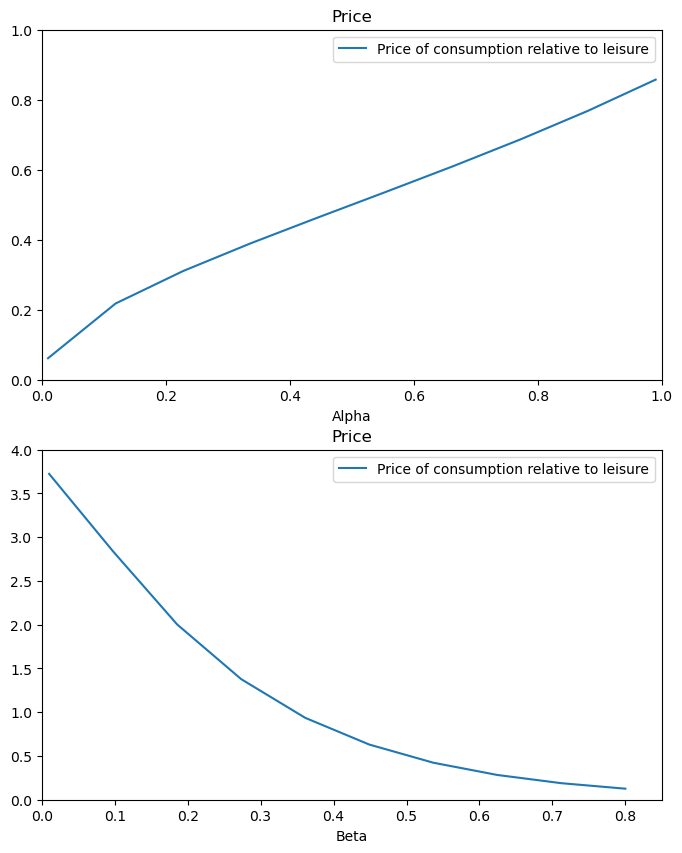

In [12]:
# a. figure with alpha on x-axis
fig = plt.figure(figsize=(8,10))
dx = fig.add_subplot(2,1,1)
dx.plot(alpha_vec_num, p_vec_num_alpha, label='Price of consumption relative to leisure')
dx.set_xlim([0.0,1]) # 
dx.set_ylim([0,1]) #
dx.set_title("Price")
dx.set_xlabel("Alpha") 
dx.legend(loc= 'upper right')

# b. figure with beta on x-axis
dx = fig.add_subplot(2,1,2)
dx.plot(beta_vec_num, p_vec_num_beta, label='Price of consumption relative to leisure')
dx.set_xlim([0.0,0.85]) # 
dx.set_ylim([0,4]) #
dx.set_title("Price")
dx.set_xlabel("Beta") 
dx.legend(loc= 'upper right')

plt.show()

From the graphs we see the same relationship as also uncovered under the analytical solution. See that section for interpretation.

# Further analysis

In this section we will change the utility function for the consumer. The reason for this is that with a Cobb-Douglas function we make som strong assumptions about the degree of substitutability. To be specific, we assume that the income effect is equal to the substitution effect with Cobb-Douglas. However, it could easily be stated that the leisure and consumption is closer to be perfect complements (low value of $\sigma$), because you cannot enjoy leisure without consumption, and consumption without time to consume is also not that valuable. We will also see how an assumption about leisure and consumption is more like perfect substitutes (high value of $\sigma$) will affect the price change for a change in $\beta$. Our new utility function is: 

$$
\begin{aligned}
& u =(c^{\frac {\sigma-1}{\sigma}}+l^{\frac {\sigma-1}{\sigma}})^{\frac {\sigma}{\sigma-1}}, 0<\sigma<\infty \\
 & \text{s.t.}\\
 & I=\Pi + w*L=p*c +w*l \\
\end{aligned}
$$

In [15]:
#call ces-class
ces=ces.numerical_solution_ces()

 Step 22.00: Beta = 0.20. Sigma = 0.10  p = 3.79 ->  -0.00001903. Good clearing = -0.00. Labor clearing = -0.00. Consumption = 39.46
 Step 25.00: Beta = 0.45. Sigma = 0.10  p = 0.48 ->  -0.00007119. Good clearing = -0.00. Labor clearing = -0.00. Consumption = 65.67
 Step 32.00: Beta = 0.70. Sigma = 0.10  p = 0.13 ->   0.00003616. Good clearing = 0.00. Labor clearing = 0.00. Consumption = 82.60
 Step 22.00: Beta = 0.20. Sigma = 0.50  p = 2.54 ->   0.00007853. Good clearing = 0.00. Labor clearing = 0.00. Consumption = 35.70
 Step 29.00: Beta = 0.45. Sigma = 0.50  p = 0.56 ->  -0.00005531. Good clearing = -0.00. Labor clearing = -0.00. Consumption = 75.04
 Step 32.00: Beta = 0.70. Sigma = 0.50  p = 0.17 ->   0.00005796. Good clearing = 0.00. Labor clearing = 0.00. Consumption = 143.20
 Step 26.00: Beta = 0.20. Sigma = 5.00  p = 1.18 ->   0.00006615. Good clearing = 0.00. Labor clearing = 0.00. Consumption = 29.49
 Step 30.00: Beta = 0.45. Sigma = 5.00  p = 0.82 ->   0.00002700. Good clear

(0.0, 5.0)

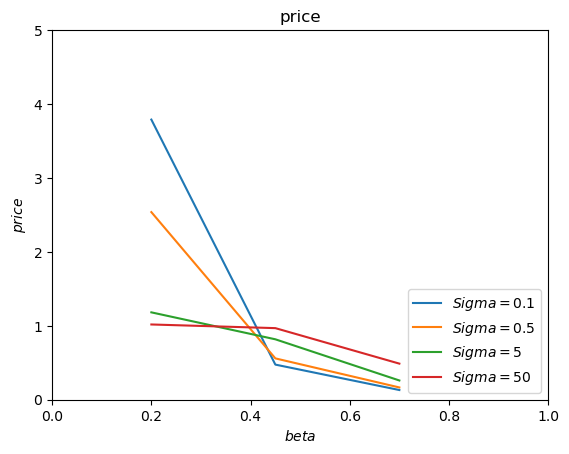

In [16]:
#Sigma

#a. Specify list of values of sigma to be considered
sigma_values=[0.10,0.5,5,50]

#b. Create empty vectors to be filled
beta_vec_num = np.empty((3,))
sigma_vec_num = np.empty((4,))
p_vec_num_beta_ces=np.empty((3,4))
c_clearing_beta_ces=np.empty((3,4))
l_clearing_beta_ces=np.empty((3,4))

#c. initiate plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#d. solve model using for different values of beta and sigma + plot relationship
for j, sigma in enumerate(sigma_values):
    sigma_baseline=ces.par.sigma
    ces.par.sigma=sigma
    sigma_vec_num[j] = sigma
    for i, beta in enumerate(np.linspace(start=0.2, stop = 0.7, num=3)):
        # Call find_relative_price with current alpha value
        beta_baseline=ces.par.beta
        ces.par.beta=beta
        beta_vec_num[i]=beta
        p_vec_num_beta_ces[i,j], c_clearing_beta_ces[i,j], l_clearing_beta_ces[i,j] = ces.find_relative_price(tol=1e-4, p_lower=0, p_upper=1000)
        ces.par.beta=beta_baseline
    ces.par.sigma=sigma_baseline
    ax.plot(beta_vec_num,p_vec_num_beta_ces[:,j],label=f'$Sigma = {sigma}$')
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$beta$')
ax.set_ylabel('$price$')
ax.set_title('The relationship between price, sigma and beta')
ax.set_xlim([0,1])
ax.set_ylim([0,5])


The results see from the figure above is in line with our expectations. Let's consider a decrease a $\beta$. This will give a lower supply in this model. Ceteris paribus this will give a lower price, but the elasticity of substitution will have an influence on the quantivately change. For $\sigma$ close to 0, we have almost perfect complements. Therefore, if the supply of goods decrease, the consumer will have to pay more for the good in order to keep a balance between leisure and consumption. This will lead to a big price decreases, i.e. the blue curve. The opposite will be true for a high degree of substitutability, which is also what we can see from the red curve above.

# Conclusion

Add concise conclusion. 